# Step 6b: Calculate coverage given the network outputs

In [1]:
parameter_code = "c0" # ----- CHANGE FOR DESIRED PARAMETER CODE
number_features = 5

In [2]:
import psutil
import shutil

# Check RAM
mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {mem.available / (1024 ** 3):.2f} GB")

# Check disk space
total, used, free = shutil.disk_usage("/")
print(f"Total Disk Space: {total / (1024 ** 3):.2f} GB")
print(f"Used Disk Space: {used / (1024 ** 3):.2f} GB")
print(f"Free Disk Space: {free / (1024 ** 3):.2f} GB")

Total RAM: 187.03 GB
Available RAM: 125.75 GB
Total Disk Space: 19.52 GB
Used Disk Space: 8.26 GB
Free Disk Space: 10.24 GB


In [3]:
import sys
import os

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scienceplots
plt.style.use("science")

import torch

from numba import cuda 
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


%matplotlib inline

from helpers.likelihood_visualizers import make_c_grid, c_scan_1d, c_scan_2d, c_scan_3d, c_scan_3d_with_confusion
from helpers.test_statistics import get_test_statistic_rate_at_c_points, get_errorbands, get_N_sig_obs_at_c_point
#from helpers.bootleg_carl import *
from helpers.network_training import NeuralNet
from helpers.utils import np_to_torch, crop_feature
from helpers.plotting import plot_features

In [ ]:
# computing

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

seed = 1

Using device: cpu


In [45]:
# just to test?
run_id = f"dense_s1_{parameter_code}_f{number_features}"

import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
with open(f"run_configs/{run_id}.yml", "r") as file:
    run_configs = yaml.safe_load(file)

## Data preparation


Load in data

In [46]:
N_train = int(run_configs["bkg.N_train"])
samples_dir = workflow["sampling"]["output_dir"]
identity_code = run_configs["input_precode"]
features = run_configs["features"]
n_features = len(features)
parameter_code = run_configs["parameter_code"]
network_id = run_configs["network_id"]

In [47]:
# load in the samples
samples_SM = np.load(f'{samples_dir}/plain_real/{identity_code}/{parameter_code}/x_sm.npy')[:,features]
samples_alt = np.load(f'{samples_dir}/plain_real/{identity_code}/{parameter_code}/x_alt_{parameter_code}.npy')[:,features]
samples_bkg = np.load(f'{samples_dir}/plain_real/delphes_b0/{parameter_code}/x_bkg.npy')[:,features]
# load in the theta values
theta_alt = np.load(f'{samples_dir}/plain_real/{identity_code}/{parameter_code}/theta_alt_{parameter_code}.npy')
theta_alt_sm = np.load(f'{samples_dir}/plain_real/{identity_code}/{parameter_code}/theta_alt_{parameter_code}.npy')

# crop to the number of desired signal events
samples_SM = samples_SM[:N_train]
samples_alt = samples_alt[:N_train]
samples_bkg = samples_bkg[:N_train]
theta_alt = theta_alt[:N_train]
theta_alt_sm = theta_alt_sm[:N_train]


Test sets

In [48]:
test_set_codes = ["sm"]
targets = [0]

print(test_set_codes)

test_sets = {}

for test_code in test_set_codes:
    test_sets[test_code] = shuffle(np.load(f'{samples_dir}/plain_real/{identity_code}/{parameter_code}/x_{test_code}_test.npy')[:,features], random_state = 7)

test_sets["bkg"] = shuffle(np.load(f'{samples_dir}/plain_real/delphes_b0/{parameter_code}/x_bkg_test.npy')[:,features], random_state = 7)

['sm']


Preprocess (Standard Scale)

In [49]:
with open(f"models/scaler_{network_id}", "rb") as ifile:
    scaler = pickle.load(ifile)

# transform
samples_SM = scaler.transform(samples_SM)
samples_alt = scaler.transform(samples_alt)
samples_bkg = scaler.transform(samples_bkg)

print(test_set_codes)

for test_code in test_sets.keys():
    test_sets[test_code] = scaler.transform(test_sets[test_code])

['sm']


Plot hists

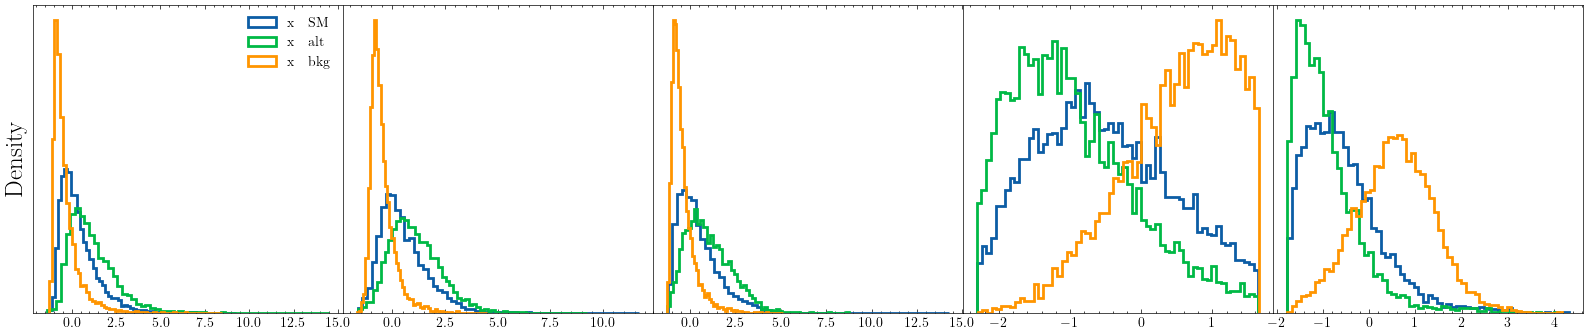

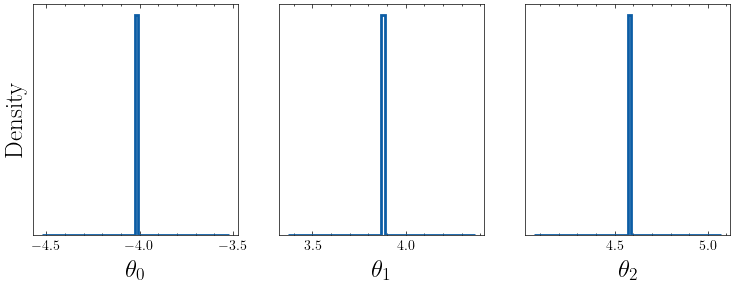

In [50]:
        
nb = 60
bins = [np.linspace(-2, 5, nb) for i in range(n_features)]
axis_labels = ["$m_\mathrm{tot}$", "$p_{T_{aa}}$", "$p_{T_{bb}}$", "$\Delta R_{aa}$", "$\Delta R_{bb}$"]

plot_features([samples_SM, samples_alt, samples_bkg], 
             ["x ~ SM", "x ~ alt", "x ~ bkg"], ["" for i in range(n_features)], nb)



# plot theta
fig, ax = plt.subplots(1, 3, figsize = (3*3, 3))

for i in range(3):
    ax[i].hist(theta_alt[:,i], bins = nb, density = True, histtype = "step", label= "alt", linewidth = 2)
    ax[i].set_xlabel(f"$\\theta_{i}$", fontsize = 18)
    ax[i].set_yticks([])
    
ax[0].set_ylabel("Density", fontsize = 18)
plt.show()

## Evaluation

In [ ]:
# load in the networks

seeds = [1, 2, 3,  4, 5]
seeds = [1]

dense_nets_eval_seeds = {s:{"Ssm_Salt":NeuralNet(n_inputs = n_features + 3, layers = run_configs["network.layers"]), 
                   "B_Salt":NeuralNet(n_inputs = n_features + 3, layers = run_configs["network.layers"]), 
                   "Ssm_B":NeuralNet(n_inputs = n_features, layers = run_configs["network.layers"],), 
                  } for s in seeds}


for key in dense_nets_eval_seeds[1].keys():
    
    for s in seeds:
        if key =="Ssm_B":
            if len(parameter_code) == 2:
                checkpoint = torch.load(f"models/dense_s{s}_c0_f{n_features}_{key}_best_model.pt", map_location=device)
            if len(parameter_code) == 4:
                checkpoint = torch.load(f"models/dense_s{s}_c0c1_f{n_features}_{key}_best_model.pt", map_location=device)
        else:
            checkpoint = torch.load(f"models/dense_s{s}_{parameter_code}_f{n_features}_{key}_best_model.pt", map_location=device)
        dense_nets_eval_seeds[s][key].load_state_dict(checkpoint["model_state_dict"])
        dense_nets_eval_seeds[s][key].eval().to(device)
    

/tmp/ipykernel_2482288/161893450.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"models/dense_s{s}_{parameter_code}_f{n_features}_{key}_best_m

In [52]:
lower_limits = [-1.4, -0.45, -.5] # 1D
upper_limits = [.4, 0.55, 0.5] # 1D


N_sig_SM_target = 3600
N_bkg_SM_target = 8120

n_coverage = 20

test code sm at (0, 0, 0) has N_sig 3600.0, sig frac = 0.30716723549488056
dataset # 0 // num signal events: 3610 // num background events: 8115


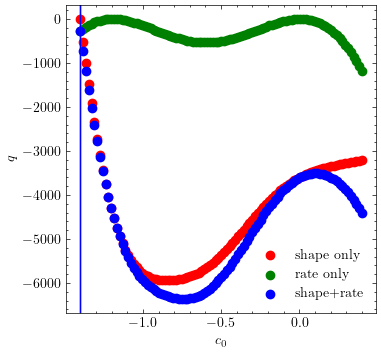

dataset # 1 // num signal events: 3551 // num background events: 8034


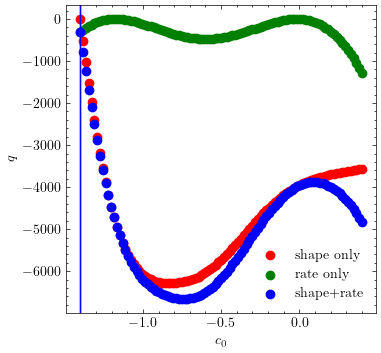

dataset # 2 // num signal events: 3567 // num background events: 7991


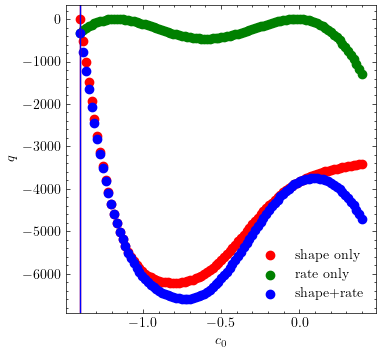

dataset # 3 // num signal events: 3609 // num background events: 8087


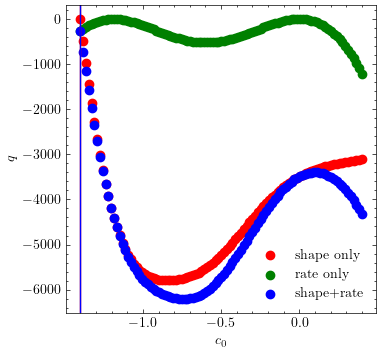

dataset # 4 // num signal events: 3519 // num background events: 8127


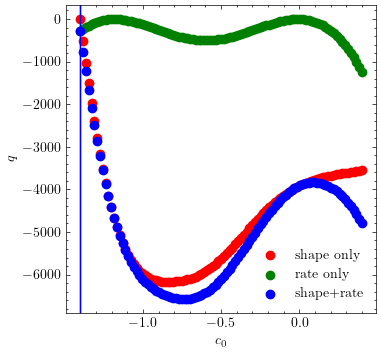

dataset # 5 // num signal events: 3650 // num background events: 8044


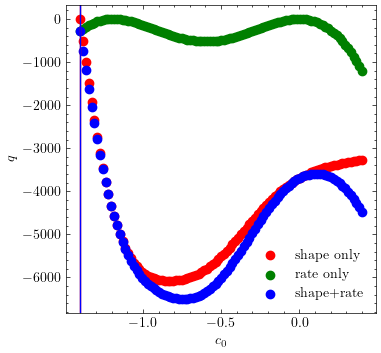

dataset # 6 // num signal events: 3708 // num background events: 8133


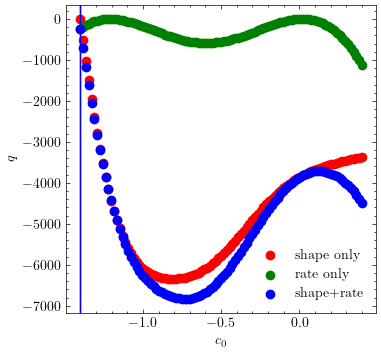

dataset # 7 // num signal events: 3697 // num background events: 8034


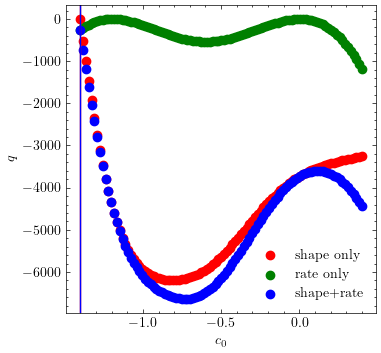

dataset # 8 // num signal events: 3590 // num background events: 8135


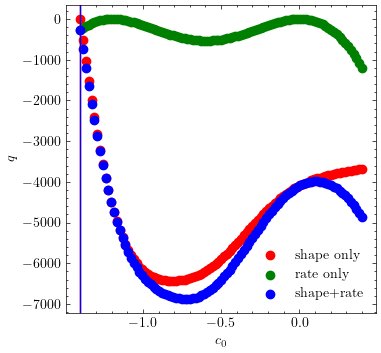

dataset # 9 // num signal events: 3535 // num background events: 8235


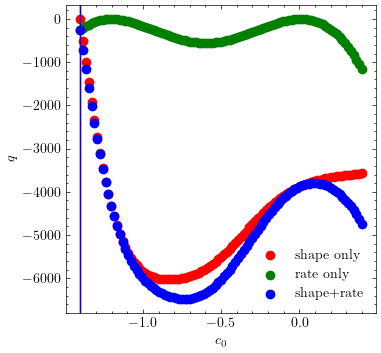

dataset # 10 // num signal events: 3611 // num background events: 8061


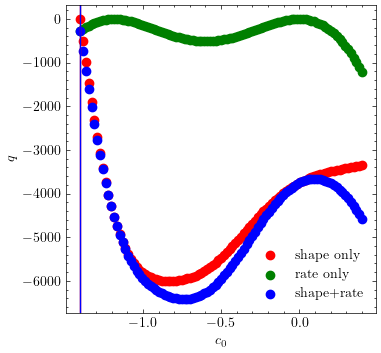

dataset # 11 // num signal events: 3588 // num background events: 8132


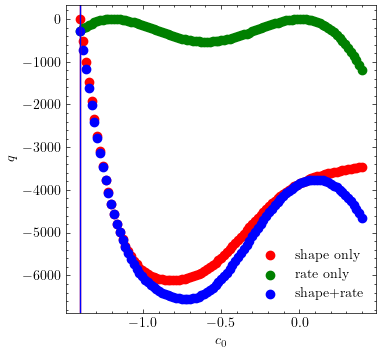

dataset # 12 // num signal events: 3648 // num background events: 8136


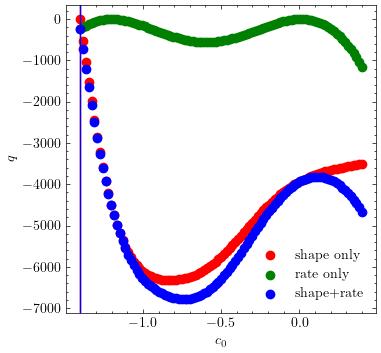

dataset # 13 // num signal events: 3512 // num background events: 8200


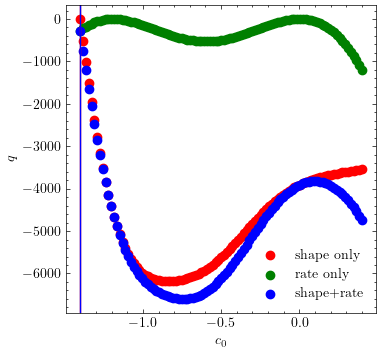

dataset # 14 // num signal events: 3634 // num background events: 8138


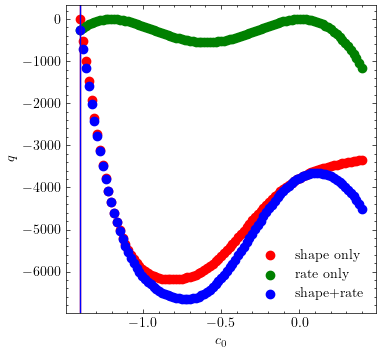

dataset # 15 // num signal events: 3727 // num background events: 8145


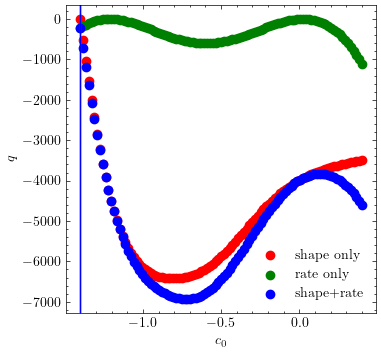

dataset # 16 // num signal events: 3606 // num background events: 8100


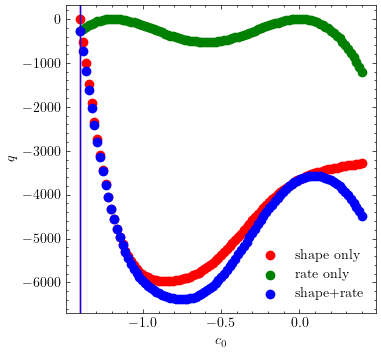

dataset # 17 // num signal events: 3578 // num background events: 8143


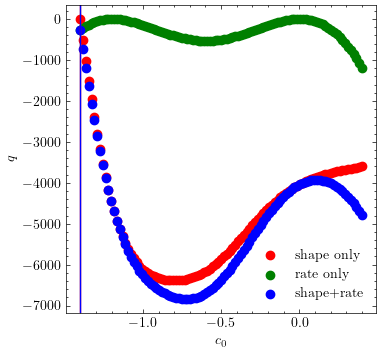

dataset # 18 // num signal events: 3749 // num background events: 8030


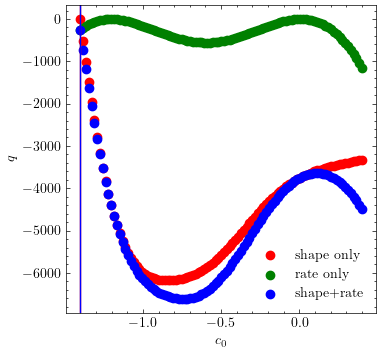

dataset # 19 // num signal events: 3551 // num background events: 8102


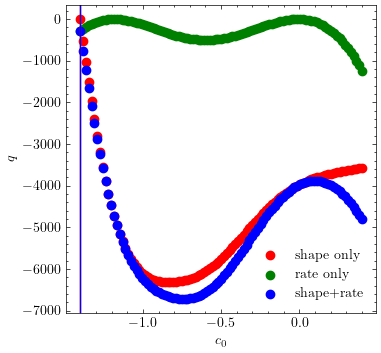

Done


In [53]:
# 1D
    
if len(parameter_code) == 2:
    
    results_dict_rate_only = {}
    results_dict_all = {}
    
    # make the c_grid
    c_grid, c_scans, edges = make_c_grid(101, lower_limits, upper_limits, parameter_code[-1])
    
    for i, test_code in enumerate(test_set_codes[:]):
        
        results_dict_rate_only[test_code] = {c:0 for c in range(n_coverage)}
        results_dict_all[test_code] = {c:0 for c in range(n_coverage)}
        
        if parameter_code[-1] == "0":
            loc_c_point = (targets[i],0,0)
        elif parameter_code[-1] == "1":
            loc_c_point = (0,targets[i],0)
        elif parameter_code[-1] == "2":
            loc_c_point = (0,0,targets[i])
                    
        # get the number of signal events that we would expect that c point to have
        loc_N_sig_obs = get_N_sig_obs_at_c_point(workflow["sampling"]["input_dir"], identity_code, loc_c_point, N_sig_SM_target)
        
        # get f_S for the c point
        loc_f_S = loc_N_sig_obs / (N_bkg_SM_target + loc_N_sig_obs)
        
        print(f"test code {test_code} at {loc_c_point} has N_sig {loc_N_sig_obs}, sig frac = {loc_f_S}")
        
        # generate the test set
        
        for c in range(n_coverage):
            
            
            np.random.seed(c)
            np.random.shuffle(test_sets[test_code])
            np.random.shuffle(test_sets["bkg"])
            
            trial_dataset_N_sig = np.random.poisson(N_sig_SM_target)
            trial_dataset_N_bkg = np.random.poisson(N_bkg_SM_target)
            print("dataset #", c, "// num signal events:",  trial_dataset_N_sig, "// num background events:", trial_dataset_N_bkg)
        
            loc_test_set_sig = test_sets[test_code][:int(trial_dataset_N_sig)]
            loc_test_set_bkg = test_sets["bkg"][:int(trial_dataset_N_bkg)]
            if loc_test_set_sig.shape[0] < int(trial_dataset_N_sig):
                print("CAUTION: not enough signal events in test set.")
            if loc_test_set_bkg.shape[0] < trial_dataset_N_bkg:
                print("CAUTION: not enough background events in test set.")
            loc_test_set = np.vstack([loc_test_set_sig, loc_test_set_bkg])


            # evaluate the rate-only test statistic for every point in the c_grid
            loc_q_rate, N_sig_c_scan = get_test_statistic_rate_at_c_points(workflow["sampling"]["input_dir"], 
                                                                          identity_code, 10*c_grid, 
                                                                          N_sig_SM_target, N_bkg_SM_target, loc_test_set.shape[0])

            results_dict_rate_only[test_code][c] = loc_q_rate
            results_dict_rate_only["cscans"] = c_scans


            loc_q_all = c_scan_1d(dense_nets_eval_seeds, device, loc_test_set, N_sig_c_scan, N_sig_SM_target, N_bkg_SM_target, c_grid, c_scans, 
                                   parameter_code[-1], seeds, q_rate = loc_q_rate)


            results_dict_all[test_code][c] = loc_q_all
 
    print("Done")


In [54]:
with open(f"preplot_pickles/coverage_dict_rate_only_{parameter_code}.pkl", "wb") as f:
    pickle.dump(results_dict_rate_only, f)

with open(f"preplot_pickles/coverage_dict_all_{parameter_code}_f{n_features}.pkl", "wb") as f:
    pickle.dump(results_dict_all, f)


In [55]:
print(number_features)

5
